<a href="https://colab.research.google.com/github/RyanChen12035/capstone/blob/main/two_tower_BERTmodel_training_TSMC_IT_BSID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.8.0 --quiet
!pip install transformers==4.15.0 --quiet
!pip install scikit-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 67.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.8.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a0996d98-9e44-4b90-027e-d26e7be2439d)


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate, Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()
import sklearn as sk
import os
from nltk.data import find
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("./job_PII_diagnosis_5.csv", error_bad_lines=False)
df.head(2)

<ipython-input-5-d5b672055e87>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("./job_PII_diagnosis_5.csv", error_bad_lines=False)


,prompt,related_to_job
0,"Being a C++ GRAPHICS PROGRAMMER at BY, HM, M...",1
1,I am doing my job in Customer Success and the ...,1


In [ ]:
# data split
X_train, X_test, y_train, y_test = train_test_split(df['prompt'], df['related_to_job'], test_size=0.2, random_state=42)

In [ ]:
#allow us to get the hidden layer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
X_train_list = X_train.apply(lambda x: x.replace('\xa0', ' ')).tolist()
X_val_list = X_test.apply(lambda x: x.replace('\xa0', ' ')).tolist()

# train
bert_train_tokenized = bert_tokenizer(X_train_list,
    max_length=128,
    truncation=True,
    padding='max_length',
    return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
    bert_train_tokenized.token_type_ids,
    bert_train_tokenized.attention_mask]
bert_train_labels = np.array(y_train)

# valdation
bert_val_tokenized = bert_tokenizer(X_val_list,
    max_length=128,
    truncation=True,
    padding='max_length',
    return_tensors='tf')
bert_val_inputs = [bert_val_tokenized.input_ids,
    bert_val_tokenized.token_type_ids, # if single sentence (0, 0, 0, 0) (this case), but if we have two segment seperated by [SEP] like question and answering, it would be (0,0,0, 1, 1, 1..)
    bert_val_tokenized.attention_mask] # for identify padding [1, 1, 1, 1, 1, 1, 1, 0, 0, 0], padding start with token number 7
bert_val_labels = np.array(y_test)

In [ ]:
print(X_train_list[0])
print(bert_train_labels[0])

Shifts:  Morning, Day, Evening, Weekend , Part-Time and Full-Time Pick orders that come through the app, pack the order and hand off to our drivers.
1


In [ ]:
text = X_train_list[0]
encoded_input = bert_tokenizer.encode_plus(text, return_tensors='pt')
encoded_input['input_ids'].size(1)

38

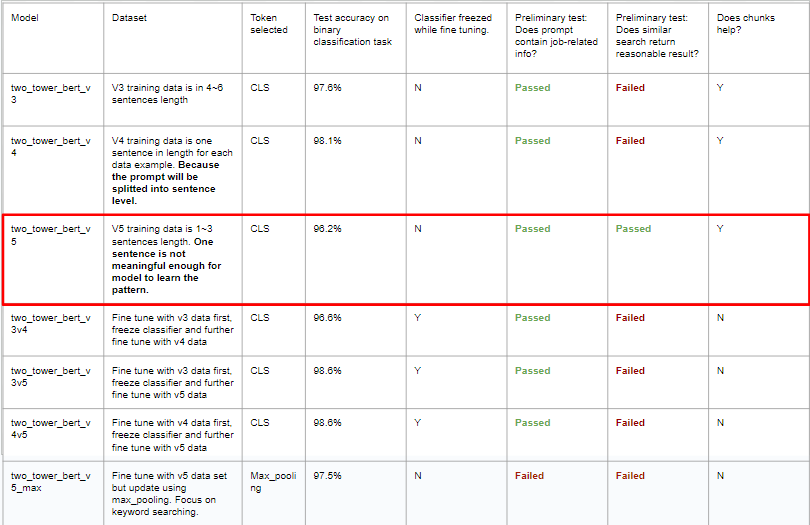

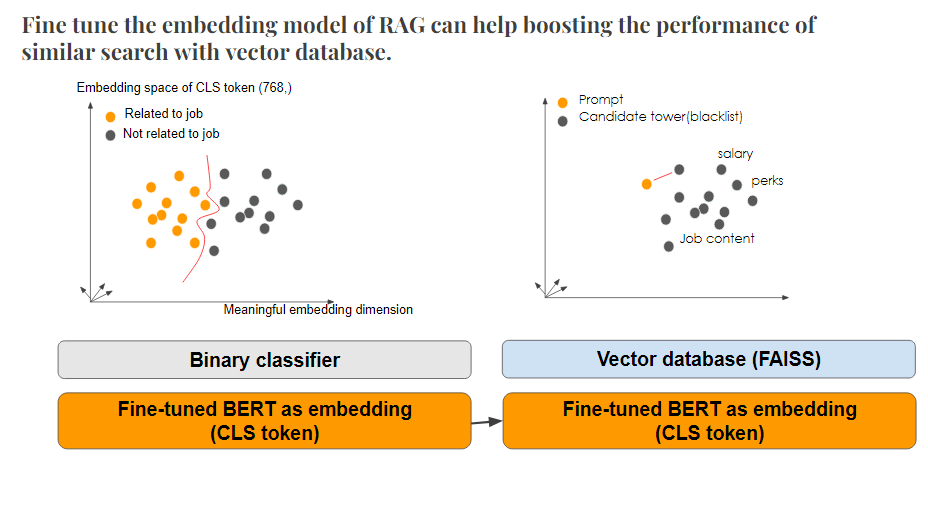

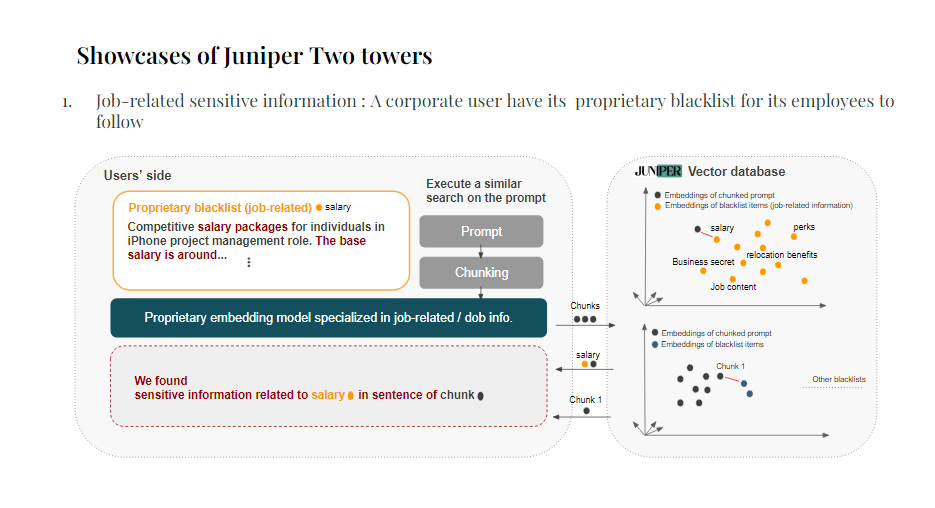

In [ ]:
#12 layers of transformer
#A drop out layer + dense layer with 100 hidden layer size on top + final layer with sigmoid as activation function
def create_bert_cls_model(bert_base_model,
                          max_sequence_length=128,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.0001): #0.0005
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    bert_base_model.trainable = True #True

    #input layers of BERT, shape (batch, max_sequence_length), model will be fit with bert_train_tokenized
    input_ids = Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids')
    token_type_ids = Input(shape=(max_sequence_length,), dtype=tf.int32, name='token_type_ids')
    attention_mask = Input(shape=(max_sequence_length,), dtype=tf.int32, name='attention_mask')

    inputs = [input_ids, token_type_ids, attention_mask]

    #BERT output, last_hidden_state shape (batch, max_sequence_length, embedding dimensions)
    bert_output = bert_base_model(input_ids=input_ids,
                                  token_type_ids=token_type_ids,
                                  attention_mask=attention_mask)

    #Extract the CLS token's output, the embedding representation of first token of every sentence, shape(batch, embedding dimensions)
    # cls_token_output = bert_output[0][:, 0, :] # CLS token output from the last layer
    pooled_output = GlobalMaxPooling1D()(bert_output[0])

    #Add a dropout layer
    x = Dropout(dropout)(pooled_output)

    #Add a fully connected layer for classification
    x = Dense(hidden_size, activation='relu')(x)

    #Final output layer for classification, assuming it's binary task
    output = Dense(1, activation='sigmoid')(x)

    #Model complie
    classification_model = Model(inputs=inputs, outputs=output)
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='binary_crossentropy',
                                 metrics=['accuracy'])
    return classification_model

In [ ]:
bert_cls_model_classification = create_bert_cls_model(bert_model)

In [ ]:
history_cls_bert= bert_cls_model_classification.fit(bert_train_inputs,
                                                    bert_train_labels,
                                                    epochs=1, #2
                                                    batch_size=16, #8
                                                    validation_data=(bert_val_inputs, bert_val_labels))

#v3
# 56/567 accuracy 0.95,data examples 4000,batch 8,lr 0.00005,version1 data
# 12/100 accuracy 0.92,data examples 2000,batch 16,lr 0.0001,version2 data
# 39/100 accuracy 0.92,data examples 2000,batch 16,lr 0.0001,version3 data
#v4
# 14/118 loss: 0.2994 - accuracy: 0.8661 batch 16,lr 0.0001 version4 data
# 35/118 loss: 0.1629 - accuracy: 0.9321
# 60/118 loss: 0.1210 - accuracy: 0.9531

152/152 [==============================] - 2324s 15s/step - loss: 0.0956 - accuracy: 0.9674 - val_loss: 0.0237 - val_accuracy: 0.9934


In [ ]:
bert_cls_model_classification.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

In [ ]:
bert_cls_model_classification.save('./two_tower_bert_v5_max.h5')

In [ ]:
from google.colab import drive

# mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
bert_cls_model_classification.save('./drive/MyDrive/two_tower_bert_v5_max.h5')

In [ ]:
from tensorflow.keras.models import load_model

custom_objects = {'TFBertModel': TFBertModel}
model = load_model('./two_tower_bert.h5', custom_objects=custom_objects)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

BERT as the embedding for the vector database

In [ ]:
def generate_embedding(text, model):
  bert_embedding_model = Model(inputs=[model.input],
                               outputs=model.get_layer('tf.__operators__.getitem').output)
  bert_train_tokenized = bert_tokenizer(text,
                                        max_length=128,
                                        truncation=True,
                                        padding='max_length',
                                        return_tensors='tf')
  bert_train_inputs = [bert_train_tokenized.input_ids,
                       bert_train_tokenized.token_type_ids,
                       bert_train_tokenized.attention_mask]
  return bert_embedding_model.predict(bert_train_inputs)

text = X_train_list[2]
embeddings = generate_embedding(text, model)
embeddings.shape

(1, 768)

In [ ]:
!pip install faiss-gpu transformers torch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 12.8 MB/s eta 0:00:00


In [ ]:
import faiss
import numpy as np

dimension = 768  # Dimension of BERT-base embeddings
nlist = 50  # Number of clusters for quantization, adjust based on your dataset size

# Using an IndexFlatL2 for simplicity, which is a basic but exact method for similarity search
index = faiss.IndexFlatL2(dimension)

# For larger datasets, consider using an IVF index to speed up search at the cost of slight accuracy loss
# quantizer = faiss.IndexFlatL2(dimension)
# index = faiss.IndexIVFFlat(quantizer, dimension, nlist, faiss.METRIC_L2)
# index.train(embeddings) # You need to train the index with some embeddings if using IVF

In [ ]:
def embedding_vectordatabase(embedding):
  embeddings = np.array(embedding, dtype="float32")
  embeddings = embeddings.reshape(-1, embeddings.shape[-1])
  return embeddings


# Add embeddings to the index
index.add(embedding_vectordatabase(embeddings))

In [ ]:
"""
Business Analyst - CRM and the salary range is negotiable Our passion for improving quality of life through geography is at the heart of everything we do.
Esri’s geographic information system (GIS) technolog

"""

In [ ]:
query_text = "My name is Ryan and I have a headache"
query_embedding = generate_embedding(query_text, model)
query_embedding = embedding_vectordatabase(query_embedding)

# Search the index
k = 5
distances, indices = index.search(query_embedding, k)

print("Indices of closest embeddings:", indices)
print("Distances:", distances)

Indices of closest embeddings: [[ 0 -1 -1 -1 -1]]
Distances: [[2.6915427e+02 3.4028235e+38 3.4028235e+38 3.4028235e+38 3.4028235e+38]]


In [ ]:
num_vectors = index.ntotal
print(f"The index contains {num_vectors} vectors.")

The index contains 1 vectors.


In [ ]:
# I am a project manager in APPLE, and I don't want these data to be revealed. Save it in the customized vector database
level_four_job = ["Competitive salary for iPhone project management roles",
                  "Relocation benefits for Apple Cupertino campus positions",
                  "Exclusive health and wellness benefits for iPhone development team members",
                  "Stock options and bonuses for iPhone project milestones",
                  "Collaborative workspaces at Apple's Silicon Valley locations",
                  "Professional development programs for iOS project leads",
                  "Confidentiality agreements for upcoming iPhone projects",
                  "Global travel opportunities for iPhone supplier audits",
                  "Flexible working hours for Apple's product development teams",
                  "Team-building retreats for iPhone project managers"]

for input in level_four_job:
  embeddings = generate_embedding(input, model)
  index.add(embedding_vectordatabase(embeddings))

num_vectors = index.ntotal
print(f"The index contains {num_vectors} vectors.")

The index contains 11 vectors.


In [ ]:
# test data for Not Related to Job, Explanation: Completely unrelated to the project management role at Apple, so it should not be flagged by the blacklist.
"Join our culinary team to explore innovative vegan cuisine and contribute to sustainable dining."
# Indices of closest embeddings: [[ 5 10  3  7  8]]
# Distances: [[66.25166 73.83598 82.73463 83.92089 88.1475 ]]

# test data for Related to Job but Not in the Blacklist, Explanation: While this is related to the technology and design fields, and potentially relevant to someone working on iPhone projects, it doesn't directly trigger any specific blacklist terms related to project management, salary, location, or benefits.
"Opportunity for a UX designer to influence the next generation of mobile applications."
# Indices of closest embeddings: [[9 7 3 8 5]]
# Distances: [[36.14649  42.72695  44.93425  47.048252 50.511066]]

# Related to Job and in the Blacklist. Explanation: This prompt hits multiple blacklist criteria: the role's focus (iPhone project manager), location (Cupertino campus), salary and stock options, and specific benefits like global travel and team-building retreats. It's closely aligned with the job description specifics you're aiming to filter out.
"Apple is seeking an iPhone project manager based at our Cupertino campus, offering a competitive salary, stock options, and exclusive benefits, including team-building retreats and global travel opportunities for project oversight."
# Indices of closest embeddings: [[9 3 8 6 1]]
# Distances: [[28.694798 40.38536  42.107452 44.624413 44.68187 ]]

# 1: Inquiry about Screen Time Effects
"I've been experiencing frequent headaches and eye strain lately, which I suspect might be related to my extensive screen time. Given my role overseeing the integration of health features into the next iPhone model, I'm constantly on my device, reviewing designs and communicating with our team in Cupertino. Could this be causing my symptoms? Any advice on mitigating these effects would be greatly appreciated."
# Indices of closest embeddings: [[ 0  2  7  8 10]]
# Distances: [[ 67.89299 531.2768  633.97546 646.0087  664.3931 ]]

# Question about Wrist Pain
"Lately, I've been experiencing persistent wrist pain, possibly from using my phone and laptop so much. Working closely with our Silicon Valley team to enhance user experience for the upcoming iPhone release, I often test new features and spend hours on my devices. Could this be contributing to my condition? What are your recommendations for alleviating this pain?"
# Indices of closest embeddings: [[ 2  7  8  5 10]]
# Distances: [[165.68468 213.81473 224.25032 228.40056 243.57683]]

# diagnosis_symptom
"I've been having a lot of pain in my neck and back. I've also been having trouble with my balance and coordination. I've been coughing a lot and my limbs feel weak."
# Indices of closest embeddings: [[ 0  2  7  8 10]]
# Distances: [[145.86563 765.25275 848.5806  867.8585  877.37506]]

#data from generated_symptoms_name_age_full_promptv3
query_text = """As Jane Cook, I am writing to let my doctor know about my current health status. Over the past few days, I have been experiencing fever, fatigue, and difficulty breathing, which has made it hard for me to carry out daily activities. My blood pressure is low, but my cholesterol level is normal.
  I am feeling really tired and weak, and even simple tasks like getting dressed or taking a shower leave me exhausted. My breathing is labored, and I often feel winded after just a few minutes of talking or walking. The fever has been persistent, and it's making me feel quite uncomfortable.
  Given my symptoms, I am worried that there might be something serious going on with my health. I would greatly appreciate it if you could look into this matter as soon as possible and let me know what is causing these symptoms. My email address is williamsjennifer@example.net, and my phone number is 001-974-704-4096x550. Thank you for your attention to this matter.
  I am looking forward to hearing from you soon. Please let me know if there's any additional information or tests that I need to undergo to determine the cause of my symptoms."""
# Indices of closest embeddings: [[ 0  2  7  8 10]]
# Distances: [[ 50.78079 691.00836 782.1455  798.60315 813.26685]]

#data from generated_symptoms_name_age_full_promptv3 after redacting
query_text = """
Original information:As [REDACTED], I am writing to let my doctor know about my current health status. Over the past few days, I have been experiencing fever, fatigue, and difficulty breathing, which has made it hard for me to carry out daily activities. My blood pressure is low, but my cholesterol level is normal.
  I am feeling really tired and weak, and even simple tasks like getting dressed or taking a shower leave me exhausted. My breathing is labored, and I often feel winded after just a few minutes of talking or walking. The fever has been persistent, and it's making me feel quite uncomfortable.
  Given my symptoms, I am worried that there might be something serious going on with my health. I would greatly appreciate it if you could look into this matter as soon as possible and let me know what is causing these symptoms. My email address is user@example.net, and my phone number is 000-000-0000. Thank you for your attention to this matter.
  I am looking forward to hearing from you soon. Please let me know if there's any additional information or tests that I need to undergo to determine the cause of my symptoms.
Additional information:
 - This person is more likely to identify as a female (100%) than a male (0%) based on open-source government data from the US, UK, Canada, and Australia.
 - This person is most likely to identify as White (79%) as compared to Black (19%), Other (1%), Hispanic (1%), Asian (0%) based on open source voter registration data from six southern US states.
"""
# Indices of closest embeddings: [[ 0  2  7  8 10]]
# Distances: [[ 61.194756 639.60956  731.6357   747.2034   762.112   ]]

# inject data on the blacklist to promptv3 (subtly)
query_text = """As [REDACTED], I am writing to let my doctor know about my current health status. Over the past few days,
I have been experiencing fever, fatigue, and difficulty breathing, which has made it hard for me to carry out daily activities,
including my role in overseeing the integration of new health features into the upcoming iPhone model. My blood pressure is low, but my cholesterol level is normal.
I am feeling really tired and weak, and even simple tasks like getting dressed, taking a shower, or reviewing design prototypes for our next project milestone leave me exhausted.
My breathing is labored, and I often feel winded after just a few minutes of talking or walking through our Cupertino campus to meet with the engineering team. The fever has been persistent,
making it hard to focus during our strategic planning sessions for the iPhone's health applications, and it's making me feel quite uncomfortable.
- This person is more likely to identify as a female (100%) than a male (0%) based on open-source government data from the US, UK, Canada, and Australia.
- This person is most likely to identify as White (79%) as compared to Black (19%), Other (1%), Hispanic (1%), Asian (0%) based on open source voter registration data from six southern US states.
"""
# Indices of closest embeddings: [[ 0  2  7  8 10]]
# Distances: [[ 61.28682 633.5507  727.4907  740.2074  755.8944 ]]

# inject data on the blacklist to promptv3 with chucking
query_text = """I often feel winded after just a few minutes of talking or walking through our Cupertino campus to meet with the engineering team.
"""
# Indices of closest embeddings: [[ 0  2  7  8 10]]
# Distances: [[108.96535 481.43365 574.1655  582.4253  598.46356]]

# More Obvious Modified Prompt with Blacklist Information
query_text = """As the project manager for the iPhone development team at Apple's Cupertino campus, I am writing to inform you of my current health status. Over the past few days, I have been experiencing severe fever, fatigue, and difficulty breathing. These symptoms have significantly hindered my ability to oversee the critical stages of our iPhone project, including the integration of the latest health monitoring features and coordinating with our Silicon Valley and Cupertino teams for the upcoming release.
My blood pressure has been consistently low, contrasting with my normally normal cholesterol levels. The fatigue is so overwhelming that performing my job, such as attending back-to-back meetings, managing our project deadlines, and reviewing the latest software updates for health applications on our new iPhone model, leaves me completely exhausted. The effort of just speaking during our project update calls or walking to different departments for meetings causes significant breathlessness.
"""
# Indices of closest embeddings: [[ 2  8  5  7 10]]
# Distances: [[128.25296 157.81598 164.87578 175.58789 179.93022]]


def query_similar_search(query_text, model, k):
  query_embedding = generate_embedding(query_text, model)
  query_embedding = embedding_vectordatabase(query_embedding)
  distances, indices = index.search(query_embedding, k)
  return indices, distances

# query_text = "I've been having a lot of pain in my neck and back. I've also been having trouble with my balance and coordination. I've been coughing a lot and my limbs feel weak."
indices, distances = query_similar_search(query_text, model, k=5)
print("Indices of closest embeddings:", indices)
print("Distances:", distances)


Indices of closest embeddings: [[ 2  8  5  7 10]]
Distances: [[128.25296 157.81598 164.87578 175.58789 179.93022]]
